# 고혈압 분석 모델

고혈압 판단 조건
1. 'AS1_BPLIE2S_A' 누운 자세 - 2회 sys 측정 평균 140 이상
2. 'AS1_BPLIE2D_A',누운 자세 - 2회 dia 측정 평균 90 이상
3. 'AS1_DrugHtCu' 2번 응답

## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - y: 종속변수
    - 'AS1_BPLIE2S_A'
    - 'AS1_BPLIE2D_A'
    - 'AS1_DrugHtCu'
    - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 2021-08-08
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

- 6차
  - 2021-08-12
  - 데이터 결측값 관리
    - 변수 모두 포함하라!
    - 범주형: 최빈값
    - 수치형: 평균값(kNN)
    - TOTALC 포함하라
    - 주말까지
  - DicisionTree 보는 법을 해석하라.
  - 모델 정확도 올리기

- 7차
  - 2021-08-23
  - unit 통일
  - dropout 통일
  - 모델 정확도 여전히 안좋음

- 8차
  - 2021-08-24
  - unit, dropout 다시 분리
  - 레이어 늘림

- 9차
  - 2021-08-26
  - 변수 중요도 낮은 변수 일부 제거하고 모델 돌려보기
    - 영향을 조금이라도 주는 것
      1. 'AS1_AGE'
      2. 'AS1_WEIGHT'
      3. 'AS1_B18'
      4. 'AS1_SEX'
      5. 'P3'
      6. 'AS1_B01'
      7. 'AS1_B04'
    - 나머지, 영향 없음.

- 10차
  - 2021-08-29
  - unit 통일
  - dropout 통일
 
- 11차
  - 2021-08-30
  - max_epoch = 10으로 통일

- 12차
  - 데이터셋 변경

- 13차
  - 2021-09-09
  - 데이터셋 변경
    - P1 ~ P4 -> FA1 ~ FA5 
    - columns 54

- 14차
  - 2021-09-13
  - 데이터 추가
    - AS1_WAIST3_A
    - 허리둘레
    - 계층있는 연속형
    - columns: 55

- 15차
  - 2021-09-26
  - 누락 되었던 식품군 F1 ~ F17 데이터 추가
  - 모델 제작에는 사용하지 않음

- 16차
  - 2021-10-01
  - JOBB 추가
  - 키 대신에 BMI 넣음
  - FA를 DP로 변경

- 17차
  - 2022-05-04
  - _1000 변수만으로 모델 학습

- 18차
  - 2022-05-13
  - 혈압을 예측하는 회귀모델 구현
  - _1000 변수 + 원래 쓰던거
  - 77777 to 0
    - AS1_DRDUA: 77777 to 0
    - AS1_HVSMAM: 77777 to 0

  - 그냥 삭제

- 19차
  - 2022-06-01
  - 데이터 describe
    - AS1_B01 있, 1000kcal 나눔
    - AS1_B01 있, 안 나눔
    - AS1_B01 없, 1000kcal 나눔
    - AS1_B01 없, 안 나눔
  
  - 유전적 요인 분석하기
    - 아빠: Father
    - 엄마: Mather
    - 형제자매: Sibling


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## dataset 불러오기 and 분리
- train, test

In [24]:
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/Scaled_X_220709.csv', index_col=0)
# X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/X_220706.csv', index_col=0)
raw_y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/y_220706.csv', index_col=0)

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8149 entries, EPI20_026_2_000004 to EPI20_026_2_010030
Columns: 129 entries, AS1_SEX to AS1_FMLPREL1A_3.0
dtypes: float64(129)
memory usage: 8.1+ MB


In [26]:
# AS1_B01 없, 안 나눔
# X = X.drop(columns=['AS1_B01',
#                     'AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
#                     'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
#                     'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
#                     'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
#                     'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
#                     'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
#                     'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
#                     'AS1_B24_1000',
#                     ])

# # AS1_B01 없, 1000kcal 나눔
# X = X.drop(columns=['AS1_B01',
#                     'AS1_B02', 'AS1_B03', 'AS1_B04',
#                     'AS1_B05', 'AS1_B06', 'AS1_B07',
#                     'AS1_B08', 'AS1_B09', 'AS1_B10',
#                     'AS1_B11', 'AS1_B12', 'AS1_B13',
#                     'AS1_B14', 'AS1_B15', 'AS1_B16',
#                     'AS1_B17', 'AS1_B18', 'AS1_B19',
#                     'AS1_B20', 'AS1_B21', 'AS1_B23',
#                     'AS1_B24',
#                     ])

# AS1_B01 있, 안 나눔
# X = X.drop(columns=['AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
#                     'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
#                     'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
#                     'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
#                     'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
#                     'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
#                     'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
#                     'AS1_B24_1000',
#                     ])

# 영양소(nutrients) 변수 AS1_B01(에너지), 1000kcal 나눔 (보정)
X = X.drop(columns=['AS1_B02', 'AS1_B03', 'AS1_B04',
                    'AS1_B05', 'AS1_B06', 'AS1_B07',
                    'AS1_B08', 'AS1_B09', 'AS1_B10',
                    'AS1_B11', 'AS1_B12', 'AS1_B13',
                    'AS1_B14', 'AS1_B15', 'AS1_B16',
                    'AS1_B17', 'AS1_B18', 'AS1_B19',
                    'AS1_B20', 'AS1_B21', 'AS1_B23',
                    'AS1_B24',
                    ])

In [27]:
X = X.drop(columns=['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9',
                    'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17'])

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8149 entries, EPI20_026_2_000004 to EPI20_026_2_010030
Data columns (total 90 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AS1_SEX             8149 non-null   float64
 1   AS1_STRPHYSJ        8149 non-null   float64
 2   AS1_TIED            8149 non-null   float64
 3   AS1_SLPAMSF         8149 non-null   float64
 4   AS1_DRINK_2.0       8149 non-null   float64
 5   AS1_DRINK_3.0       8149 non-null   float64
 6   AS1_SMOKEA_1.0      8149 non-null   float64
 7   AS1_SMOKEA_2.0      8149 non-null   float64
 8   AS1_SMOKEA_3.0      8149 non-null   float64
 9   AS1_EDUA            8149 non-null   float64
 10  AS1_INCOME          8149 non-null   float64
 11  AS1_DRDUA           8149 non-null   float64
 12  AS1_PHYSTB          8149 non-null   float64
 13  AS1_PHYSIT          8149 non-null   float64
 14  AS1_PHYACTL         8149 non-null   float64
 15  AS1_PHYACTM         8149 non-

In [29]:
# y = raw_y['AS1_DRUGHTCU_FILLNA']
# y = raw_y['AS1_BPLIE2S_A']
# y = raw_y['AS1_BPLIE2D_A']
y = raw_y['HYPERTENSION']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)
# X_train, X_test, y_train, y_test = train_test_split(X, raw_y, test_size=0.2, random_state=415)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6519, 90) (1630, 90) (6519,) (1630,)


In [31]:
y_train['HYPERTENSION'].value_counts().sort_index()

0    5008
1    1511
Name: HYPERTENSION, dtype: int64

In [32]:
y_test['HYPERTENSION'].value_counts().sort_index()

0    1258
1     372
Name: HYPERTENSION, dtype: int64

In [33]:
y_train['AS1_DRUGHTCU_FILLNA'].value_counts().sort_index()

1.0    5802
2.0     717
Name: AS1_DRUGHTCU_FILLNA, dtype: int64

In [34]:
y_test['AS1_DRUGHTCU_FILLNA'].value_counts().sort_index()

1.0    1466
2.0     164
Name: AS1_DRUGHTCU_FILLNA, dtype: int64

In [35]:
y_train.describe()

,AS1_DRUGHTCU_FILLNA,AS1_BPLIE2S_A,AS1_BPLIE2D_A,HYPERTENSION
count,6519.000000,6519.000000,6519.000000,6519.000000
mean,1.109986,117.450529,75.180856,0.231784
std,0.312897,18.308452,11.503083,0.422004
min,1.000000,69.000000,40.000000,0.000000
25%,1.000000,105.000000,68.000000,0.000000
50%,1.000000,115.000000,74.000000,0.000000
75%,1.000000,128.000000,82.000000,0.000000
max,2.000000,211.000000,125.000000,1.000000


In [36]:
y_test.describe()

,AS1_DRUGHTCU_FILLNA,AS1_BPLIE2S_A,AS1_BPLIE2D_A,HYPERTENSION
count,1630.000000,1630.000000,1630.000000,1630.000000
mean,1.100613,117.183436,75.042331,0.228221
std,0.300909,18.210423,11.561459,0.419815
min,1.000000,73.000000,40.000000,0.000000
25%,1.000000,105.000000,68.000000,0.000000
50%,1.000000,115.000000,74.000000,0.000000
75%,1.000000,128.000000,82.000000,0.000000
max,2.000000,204.000000,132.000000,1.000000


In [37]:
# train =  pd.concat([X['AS1_INCOME'], y], axis=1)
# train =  pd.concat([X['AS1_FMHEREL1A'], y], axis=1)
# train =  pd.concat([X['AS1_FMCVAREL1A'], y], axis=1)

In [38]:
# train.value_counts().sort_index()

In [39]:
# X_train['AS1_STRPHYSJ'].value_counts().sort_index()
# X_train['AS1_FMHEREL1A'].value_counts().sort_index()
# X_train['AS1_FMCVBREL1A'].value_counts().sort_index()

In [40]:
# X_test['AS1_STRPHYSJ'].value_counts().sort_index()
# X_test['AS1_FMHEREL1A'].value_counts().sort_index()
# X_test['AS1_FMCVBREL1A'].value_counts().sort_index()

In [41]:
UNITS = 32
EPOCH = 128
DROPOUT = 0.05
LEARNINGRATE = 0.01

In [42]:
# class ClearTrainingOutput(keras.callbacks.Callback):
#   def on_train_end(*args, **kwargs):
#     IPython.display.clear_output(wait = True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

nodes = [8, 16, 32, 40, 48, 56, 64]
scoreList = []

In [47]:
scoreList = []

for i in nodes:
  model = Sequential()
  model.add(Dense(i, activation='relu'))  # input layer requires input_dim param
  
  model.add(Dropout(DROPOUT))
  model.add(Dense(i, activation='relu'))

  model.add(Dropout(DROPOUT))
  model.add(Dense(i, activation='relu'))

  model.add(Dropout(DROPOUT))
  model.add(Dense(i, activation='relu'))

  model.add(Dropout(DROPOUT))
  model.add(Dense(i, activation='relu'))

  model.add(Dropout(DROPOUT))
  model.add(Dense(i, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  
  model.compile(loss="binary_crossentropy",
                optimizer = Adam(learning_rate = LEARNINGRATE),
                metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.2, callbacks=es)
  scores = model.evaluate(X_test, y_test)
  scoreList.append(scores[1])

for x in scoreList:
  print(f"{format(x, '.3f')}")

Epoch 21: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4779 - accuracy: 0.7718
Epoch 18: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.5025 - accuracy: 0.7736
Epoch 27: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4796 - accuracy: 0.7816
Epoch 14: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4837 - accuracy: 0.7822
Epoch 28: early stopping
51/51 [==============================] - 0s 1ms/step - loss: 0.4935 - accuracy: 0.7804
Epoch 19: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.5079 - accuracy: 0.7748
Epoch 22: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4895 - accuracy: 0.7718
0.772
0.774
0.782
0.782
0.780
0.775
0.772


In [48]:
 X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8149 entries, EPI20_026_2_000004 to EPI20_026_2_010030
Data columns (total 90 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AS1_SEX             8149 non-null   float64
 1   AS1_STRPHYSJ        8149 non-null   float64
 2   AS1_TIED            8149 non-null   float64
 3   AS1_SLPAMSF         8149 non-null   float64
 4   AS1_DRINK_2.0       8149 non-null   float64
 5   AS1_DRINK_3.0       8149 non-null   float64
 6   AS1_SMOKEA_1.0      8149 non-null   float64
 7   AS1_SMOKEA_2.0      8149 non-null   float64
 8   AS1_SMOKEA_3.0      8149 non-null   float64
 9   AS1_EDUA            8149 non-null   float64
 10  AS1_INCOME          8149 non-null   float64
 11  AS1_DRDUA           8149 non-null   float64
 12  AS1_PHYSTB          8149 non-null   float64
 13  AS1_PHYSIT          8149 non-null   float64
 14  AS1_PHYACTL         8149 non-null   float64
 15  AS1_PHYACTM         8149 non-

In [49]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 64)                5824      
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_64 (Dense)            (None, 64)                4160      
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                                                                 
 dense_65 (Dense)            (None, 64)                4160      
                                                                 
 dropout_47 (Dropout)        (None, 64)                0         
                                                                 
 dense_66 (Dense)            (None, 64)               

## 민감도 특이도

2022-09-06 추가

In [89]:
from sklearn.metrics import confusion_matrix

In [93]:
y_pred_r = model.predict(X_test)
y_pred_r = np.reshape(y_pred_r, len(y_pred_r))
y_pred = np.where((y_pred_r < 0.5), 0, 1)
(y_pred == 1).sum()

40

In [95]:
cm = confusion_matrix(y_test, y_pred)
scores = {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}
print('sensitivity: ', scores['tp'] / (scores['tp'] + scores['fn']),
      '\nspecificity: ', scores['fp'] / (scores['fp'] + scores['tn']))

sensitivity:  0.03494623655913978 
specificity:  0.021462639109697933


0.03494623655913978 0.021462639109697933


              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1258
           1       0.33      0.03      0.06       372

    accuracy                           0.76      1630
   macro avg       0.55      0.51      0.46      1630
weighted avg       0.67      0.76      0.68      1630



array([0.07262242, 0.10471573, 0.29419446, ..., 0.19883645, 0.1027202 ,
       0.27543747], dtype=float32)

In [72]:
y_test

RID
EPI20_026_2_002903    0
EPI20_026_2_001070    0
EPI20_026_2_000649    0
EPI20_026_2_003287    0
EPI20_026_2_005479    0
                     ..
EPI20_026_2_010022    0
EPI20_026_2_008349    0
EPI20_026_2_007976    0
EPI20_026_2_002268    0
EPI20_026_2_006271    0
Name: HYPERTENSION, Length: 1630, dtype: int64

## feature importance


In [50]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)


In [52]:
# Define hyperparameters
params_xgb = {"max_depth": 5,
              "eta": 0.1,
              'objective': 'binary:logistic',
              'eval_metric':'logloss',
              'early_stopping': 32
              }

num_round = 400

In [53]:
wlist = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(params=params_xgb, dtrain=dtrain, num_boost_round=num_round, evals=wlist)
xgb_model

[0]	train-logloss:0.655797	eval-logloss:0.657993
[1]	train-logloss:0.625202	eval-logloss:0.629215
[2]	train-logloss:0.599602	eval-logloss:0.60556
[3]	train-logloss:0.577548	eval-logloss:0.5858
[4]	train-logloss:0.558783	eval-logloss:0.569326
[5]	train-logloss:0.54279	eval-logloss:0.555244
[6]	train-logloss:0.528989	eval-logloss:0.543092
[7]	train-logloss:0.517137	eval-logloss:0.533108
[8]	train-logloss:0.50627	eval-logloss:0.525245
[9]	train-logloss:0.49717	eval-logloss:0.51813
[10]	train-logloss:0.488667	eval-logloss:0.511855
[11]	train-logloss:0.48111	eval-logloss:0.506884
[12]	train-logloss:0.474468	eval-logloss:0.502932
[13]	train-logloss:0.468295	eval-logloss:0.4992
[14]	train-logloss:0.463063	eval-logloss:0.495301
[15]	train-logloss:0.457543	eval-logloss:0.492165
[16]	train-logloss:0.452715	eval-logloss:0.490547
[17]	train-logloss:0.448861	eval-logloss:0.4881
[18]	train-logloss:0.444815	eval-logloss:0.486589
[19]	train-logloss:0.441506	eval-logloss:0.48526
[20]	train-logloss:0.43

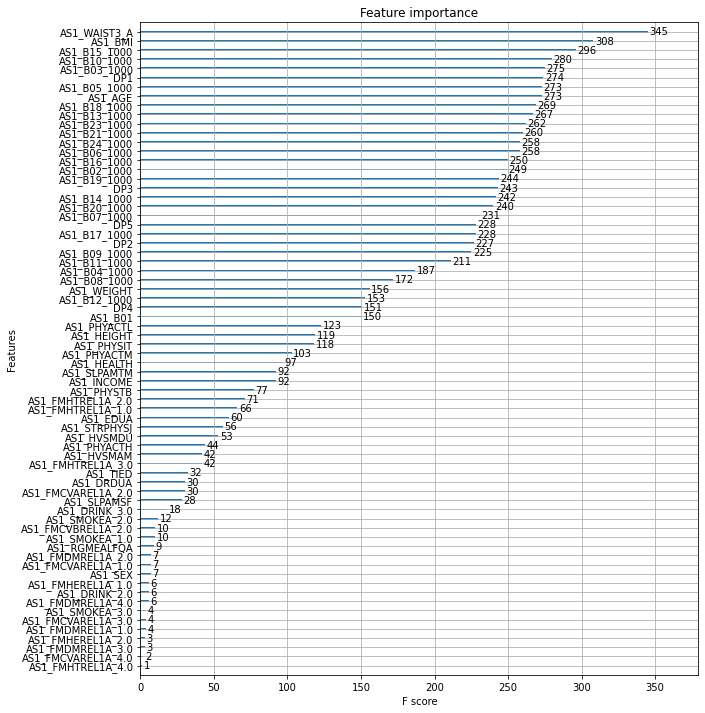

In [54]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)